# Reading SP Data

The Spectral Profiler data is available in archives with `.sl2` file endings.  These files are 

In [83]:
from functools import partial
import os
import tarfile
import glob

import plio
import libpysat

from datasketch import MinHash, MinHashLSH

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import os
files = glob.glob('*.sl2')

In [100]:
import pandas as pd
import pickle
from multiprocessing import Pool

from datasketch import WeightedMinHashGenerator
from datasketch import MinHash, MinHashLSH

from functools import partial

def extract_and_hash(f):

    s = libpysat.data.spectra.Spectra.from_file(f)
    ref1s = s.xs('REF1', level=1, axis=1)
    try:
        res, denom = ref1s.continuum_correct(nodes=[512.6, 1547.7, 2404.2],correction_nodes=[512.6, 1547.7, 2587.9], func=libpysat.transform.continuum.regression)
    except:
        print(f)
        return
    
    def compute_minhash(col, mg, **kwargs):
        m = mg.minhash(col.values)
        return m
    
    mg = WeightedMinHashGenerator(269)
    
    hashes = res.data.apply(compute_minhash, args=(mg,))
     
    keys = ['{}_{}'.format(p,i) for i, p in enumerate(res.loc['PRODUCT_ID'].values)]
    
    return list(zip(keys, hashes))

def add_to_lsh(lsh, hash_set):
    lsh = pickle.loads(lsh)
    with lsh.insertion_session() as session:
        for key, mhash in hash_set:
            session.insert(key, mhash)
    return

def extract_spc(f):
    tar = tarfile.open(f)
    list(map(tar.extract, [m for m in tar.getmembers() if '.spc' in m.name]))
    fname = os.path.splitext(f)[0] + '.spc'
    
    return fname

def stream_kg(f, lsh):
    spc = extract_spc(f)
    hashes = extract_and_hash(spc)
    if hashes:
        add_to_lsh(lsh, hashes)
    os.remove(spc)

files = glob.glob('*.sl2')
lsh = MinHashLSH(threshold=0.98, num_perm=128,
                storage_config={'type':'redis',
                                'redis':{'host':'localhost',
                                         'port':9050}})
lsh = pickle.dumps(lsh)
with Pool(12) as p:
    p.map(partial(stream_kg, lsh=lsh), files)
lsh = pickle.loads(lsh)

/home/jlaura/anaconda3/envs/libpysat/lib/python3.6/site-packages/datasketch/weighted_minhash.py:128: RuntimeWarning: invalid value encountered in log
  vlog = np.log(v)
/home/jlaura/anaconda3/envs/libpysat/lib/python3.6/site-packages/datasketch/weighted_minhash.py:128: RuntimeWarning: invalid value encountered in log
  vlog = np.log(v)
/home/jlaura/anaconda3/envs/libpysat/lib/python3.6/site-packages/datasketch/weighted_minhash.py:128: RuntimeWarning: invalid value encountered in log
  vlog = np.log(v)
/home/jlaura/anaconda3/envs/libpysat/lib/python3.6/site-packages/datasketch/weighted_minhash.py:128: RuntimeWarning: invalid value encountered in log
  vlog = np.log(v)
/home/jlaura/anaconda3/envs/libpysat/lib/python3.6/site-packages/datasketch/weighted_minhash.py:128: RuntimeWarning: invalid value encountered in log
  vlog = np.log(v)
/home/jlaura/anaconda3/envs/libpysat/lib/python3.6/site-packages/datasketch/weighted_minhash.py:128: RuntimeWarning: invalid value encountered in log
  vlo

OverflowError: ('cannot convert float infinity to integer', 'occurred at index 38')

In [102]:
lsh = pickle.loads(lsh)

In [104]:
lsh.hashranges
print(lsh.hashranges)
for ht in lsh.hashtables:
    k = list(ht.keys())[0]
    print(len(ht.keys()), sys.getsizeof(k))
sys.getsizeof(k)

[(0, 64), (64, 128)]
50982 1057
54835 1057


1057

In [91]:
files = glob.glob('*.sl2')
for f in files:
    tar = tarfile.open(f)
    # Extract the spc and the ctg files
    list(map(tar.extract, [m for m in tar.getmembers() if '.spc' in m.name]))
files = glob.glob('*.spc')

with open('data.tsv', 'w') as csv:
    for i, f in enumerate(files):
        s = libpysat.data.spectra.Spectra.from_file(f).T
        s['image_name'] = os.path.splitext(f)[0]
        header = True
        if i > 0:
            header = False
        s.to_csv(csv, mode='a', sep='\t', header=header)

In [79]:
def create_lsh(lsh, hash_set):
    lsh = pickle.loads(lsh)

    [lsh.insert("{}".format(i), j) for i,j in enumerate(hash_set)]
    return lsh

lsh = MinHashLSH(threshold=0.98, num_perm=128,
                storage_config={'type':'redis',
                                'redis':{'host':'localhost',
                                         'port':9050}})
lsh = pickle.dumps(lsh)

procs = []
for i, n in enumerate([hashes[:7], hashes[7:]]):
    proc = Process(target=create_lsh, args=(lsh, n))
    procs.append(proc)
    proc.start()
    
for proc in procs:
    proc.join()
    
lsh = pickle.loads(lsh)

#lsh1 = create_lsh(hashes1)
#lsh2 = create_lsh(hashes2)

Process Process-7:
Process Process-8:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jlaura/anaconda3/envs/libpysat/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/jlaura/anaconda3/envs/libpysat/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/jlaura/anaconda3/envs/libpysat/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jlaura/anaconda3/envs/libpysat/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-79-266f24a915fe>", line 4, in create_lsh
    [lsh.insert("{}".format(i), j) for i,j in enumerate(hash_set)]
  File "<ipython-input-79-266f24a915fe>", line 4, in create_lsh
    [lsh.insert("{}".format(i), j) for i,j in enumerate(hash_set)]
  File "<ipython-input-79-266f24a915fe>", line 4, in <listcomp>
    [lsh.ins

In [17]:
lsh.query(hashes2[500])

['490', '500', '36', '116', '43']

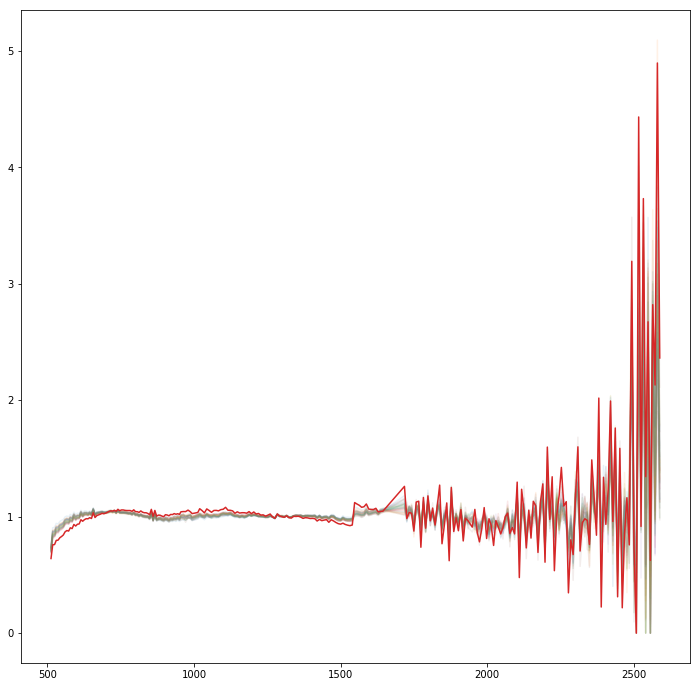

In [107]:
figsize(12,12)
for i in result:
    merged.data.T.iloc[int(i)].plot(alpha=0.1)
merged.data.T.iloc[200].plot()